In [1]:
# environment variable
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

# core libraries
import os
import jax
import time
import optax
import numpy as np
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt

# import sub-modules
from jax import random, config, vmap
# Add these to your imports in train.ipynb
from jax.scipy.optimize import minimize
from jax.flatten_util import ravel_pytree

# import local modules
from model import PINN
# from train import Train
from sampler import Sampler
from residual import Residual
from derivative import Derivative
from pde_dimless import PDE_dimless
from pde_checker import PDE_checker
from train import TrainConfig, Train
from util import subset, map_span, get_i, get_len, generate_validation_data, to_f32, tree_to_f32

# config and set the key
config.update("jax_enable_x64", True)
key = random.PRNGKey(1312)

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
pdeparams_phys = {
    "alpha_phi": 9.62e-5,
    "omega_phi": 1.663e7,
    "M": 8.5e-10 / (2 * 5.35e7),
    "A": 5.35e7,
    "L": 1e-11,
    "c_se": 1.0,
    "c_le": 5100/1.43e5,
    "x_range": (-50.0e-6, 50.0e-6),
    "t_range": (0, 1.0e5),
    "nx": 128,
    "nt": 128,
    "l_0": 2*50.0e-6,
    "t_0": 1.0e5
}
# set up the pde
pdedimless = PDE_dimless(pdeparams_phys)
pdedimless.show()

Physical Parameter  Value                    || Dimless Parameter   Value                    
alpha_phi           9.62e-05                 || P_CH                8500                     
omega_phi           1.663e+07                || P_AC1               99.504                   
M                   7.9439e-18               || P_AC2               16.63                    
L                   1e-11                    || P_AC3               0.00962                  
A                   5.35e+07                 || x_range_nd          [-0.5, 0.5]              
c_se                1                        || t_range_nd          [0, 1]                   
c_le                0.035664                 ||                                              
x_range             [-5e-05, 5e-05]          ||                                              
t_range             [0, 1e+05]               ||                                              
l_0                 0.0001                   ||             

In [3]:
# arbitrarily sample some parameters to learn
span_pde = {'x':pdedimless.x_range_nd, 't':pdedimless.t_range_nd, 'L':(1e-12,1e-10)} # 
span_model = {'x':(-0.5,0.5), 't':(0,1),'L':(0,1)}

P_temp = map_span(1e-11,span_pde['L'],span_model['L'])
key, subkey = random.split(key)
P_model = {
    'L': jnp.array([P_temp]) #jnp.sort(s.get(subkey, [2], [span_model['L']]))
}
P_phys = {
    key: map_span(value, span_model[key], span_pde[key])
    for key, value in P_model.items()
}
P_model = tree_to_f32(P_model)
P_phys = tree_to_f32(P_phys)
# generate training data for the seleceted parameters
key, subkey = random.split(key)
sols, train_data = pdedimless.generate_training_data(subkey, P_phys, num_train=128*128)
sols = tree_to_f32(sols)
train_data = tree_to_f32(train_data)
config.update("jax_enable_x64", False)


In [4]:
span_pde = {'x':pdedimless.x_range_nd, 't':pdedimless.t_range_nd, 'L':(1e-12,1e-10)} # 
span_model = {'x':(-0.5,0.5), 't':(0,1),'L':(0,1)}

In [5]:
#### set up the model
inp_idx = {'x':0, 't':1}
out_idx = {'phi':0, 'c':1}
width, depth = 16, 4
model = PINN(inp_idx, out_idx, width, depth)

In [6]:
# construct derivatives
d = Derivative(inp_idx, out_idx, span_pde, span_model)
d.create_deriv_fn('phi_t')
d.create_deriv_fn('phi_x')
d.create_deriv_fn('phi_2x')
d.create_deriv_fn('c_t')
d.create_deriv_fn('c_2x')

In [7]:
# construct residual
r = Residual(span_pde, span_model, pdedimless, d)

In [8]:
# construct sampler
s = Sampler()

# construct sampling functions
def input_single(key, P_i, train_data_i, num_data):
    keys = random.split(key, 5)
    inp = {k: {} for k in ['ic', 'bc', 'colloc', 'data']}
    
    # IC
    inp['ic']['x'] = s.get(keys[0], [16, 32, 16], [(-0.5, -0.1), (-0.1, 0.1), (0.1, 0.5)])
    inp['ic']['t'] = s.get(keys[0], [64], [(0, 0)])
    
    # BC
    inp['bc']['x'] = s.get(keys[1], [32, 32], [(-0.5, -0.5), (0.5, 0.5)])
    inp['bc']['t'] = jnp.tile(s.get(keys[1], [32], [(0, 1)]), 2)
    
    # Collocation
    x_colloc = s.get(keys[2], [64], [(-0.5, 0.5)])
    t_colloc = s.get(keys[3], [32], [(0, 1)])
    Xc, Tc = jnp.meshgrid(x_colloc, t_colloc, indexing="ij")
    inp['colloc']['x'], inp['colloc']['t'] = Xc.ravel(), Tc.ravel()
    
    # Training data
    train_sub = subset(keys[4], train_data_i, num_data)
    inp['data']['x'] = map_span(train_sub['x'], span_pde['x'], span_model['x'])
    inp['data']['t'] = map_span(train_sub['t'], span_pde['t'], span_model['t'])
    inp['data']['phi'] = train_sub['phi']
    inp['data']['c'] = train_sub['c']
        
    #Add parameters
    # for cat in inp:
    #     ref_array = inp[cat]['x']
    #     for param_key, param_value in P_i.items():
    #         inp[cat][param_key] = jnp.full(ref_array.shape, param_value, ref_array.dtype)
            
    return inp

def new_input(key, P, train_data, num_data):
    num_params = get_len(P)
    keys = random.split(key, num_params)
    out = jax.vmap(input_single, in_axes=(0, 0, 0, None))(keys, P, train_data, num_data)
    return jax.tree_util.tree_map(lambda x: jnp.reshape(x, (-1,)), out)

def subset_input(key, inp, size=16):
    keys = random.split(key,4)
    inp_sub = {}
    inp_sub['ic'] = subset(keys[0], inp['ic'], size)
    inp_sub['bc'] = subset(keys[1], inp['bc'], size)
    inp_sub['colloc'] = subset(keys[2], inp['colloc'], size)
    inp_sub['data'] = subset(keys[3], inp['data'], size)
    return inp_sub

In [9]:
# generate new input
key, subkey = random.split(key)
num_gt_to_use = 1000
inp = new_input(subkey, P_model, train_data, num_gt_to_use)

/home/fangkoukou/miniconda3/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/fangkoukou/miniconda3/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/array_creation.py:531: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(stop - start, computation_dtype) / asarray(div, dtype=computation_dtype)
/home/

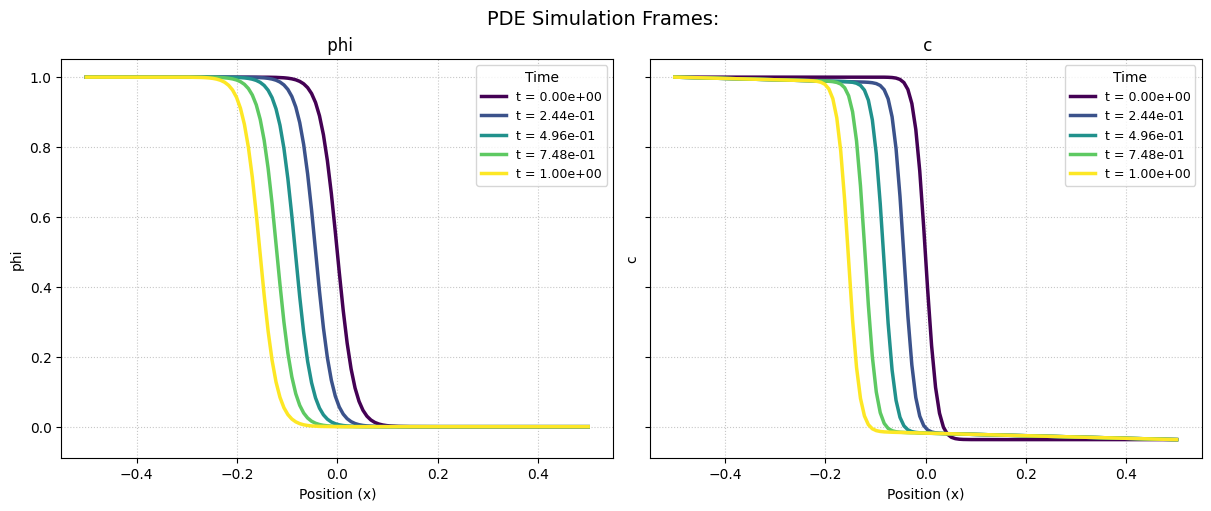

In [10]:
checker = PDE_checker()
checker.frames(get_i(sols,0))

In [11]:
# ==============================================================
# =================== TRAINING CONFIGURATION ===================
# ==============================================================

# ================ initialize training configuration ================
config = TrainConfig()
config.P_model = P_model # the parameters to be trained
config.train_data = train_data
config.log_keys_order = ['ic','bc','ac','ch','data'] # the order in which losses are printed
config.num_data = num_gt_to_use # number of actual data to fit

# ================ seperate parameter and model structure: ================ 
model_params, model_static = eqx.partition(model, eqx.is_inexact_array)
config.static = model_static


# ================ set up optimizer ================ 
max_grad_norm = 10.0
optimizer = optax.chain(
    optax.clip_by_global_norm(max_grad_norm),
    optax.adam(1.0e-3),
)
opt_state = optimizer.init(model_params)
config.optimizer = optimizer


# ================ set update sample ================ 
def update_input(key, P, train_data, num_data):
    return new_input(key, P, train_data, num_data)
    
config.update_input = update_input


# ================  set update weight ================ 
def update_weight(key, params, static, inp, cap=None):
    # reconstruct model
    model_temp = eqx.combine(params, static)

    # compute ntk weight
    subset = subset_input(key, inp, size=16)
    ntk_weight = r.compute_ntk_weights(model_temp, subset)

    # adjust weight manually
    manual_weight = {'ic': 1.0, 'bc': 1.0, 'ac': 1.0, 'ch': 1.0, 'data': 0.0}
    weighted = {k: ntk_weight[k] * manual_weight[k] for k in ntk_weight}

    # cap if requested
    if cap is not None:
        weighted = {k: jnp.minimum(v, cap) for k, v in weighted.items()}

    return weighted

config.update_weight = update_weight

# ================  loss function ================ 
def loss_fn(params, static, inp, weight_dict):
    model_temp = eqx.combine(params, static)
    loss_dict = r.compute_loss(model_temp, inp)
    weighted_loss = jnp.array(
        [weight_dict[k]*loss_dict[k] for k in ['ic','bc','ac','ch','data']]
    )
    return jnp.sum(weighted_loss), loss_dict
    
config.loss_fn = loss_fn

In [12]:
# initialize the carry
config.total_steps = 10000
config.sp1 = 25 # Resampling frequency
config.sp2 = 25 # NTK weighting frequency
config.sp3 = 500 # log frequency

key, subkey = random.split(key)
weight_dict = update_weight(key, model_params, model_static, inp)
init_carry = (subkey, inp, weight_dict, model_params, opt_state, jnp.inf, model_params)

# train
final_carry, loss_history = Train.train(config, init_carry)

2025-09-18 15:18:56.754628: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-18 15:18:57.290783: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-18 15:18:58.608108: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-18 15:19:00.127276: W external/xla/xla/service/gpu/au

Step 0      total_loss = 534897.3750  geom_loss = 6.8190e+00  epoch_elapsed = 31.211s  total_elapsed = 31.211s
Keys   :      ic      |      bc      |      ac      |      ch      |     data    
Weights: 8.2321e+05   | 7.8569e+05   | 2.6710e+02   | 1.0038e+00   | 0.0000e+00  
Losses : 2.8375e-01   | 3.3396e-01   | 1.2832e+02   | 4.6252e+03   | 2.6215e-01  
W * L  : 2.3359e+05   | 2.6239e+05   | 3.4275e+04   | 4.6426e+03   | 0.0000e+00  
Step 500    total_loss = 1752001536.0000  geom_loss = 2.0783e-01  epoch_elapsed = 0.700s  total_elapsed = 31.911s
Keys   :      ic      |      bc      |      ac      |      ch      |     data    
Weights: 3.9940e+12   | 6.0719e+12   | 4.6162e+09   | 1.0000e+00   | 0.0000e+00  
Losses : 6.1154e-05   | 7.6418e-05   | 1.8917e-01   | 1.7053e+08   | 2.5723e-03  
W * L  : 2.4425e+08   | 4.6400e+08   | 8.7322e+08   | 1.7053e+08   | 0.0000e+00  
Step 1000   total_loss = 1676663552.0000  geom_loss = 9.8955e-02  epoch_elapsed = 0.574s  total_elapsed = 32.485s
Keys 

In [15]:
# ==================================================
# =================== validation ===================
# ==================================================
jax.config.update("jax_enable_x64", True)
# =============== reconstruct the model ===============
_, _, _, final_params, _, best_loss, best_params = final_carry
final_model = eqx.combine(best_params, model_static)

# ============== prepare validation data ==============set up the validation datra validation data:
P_valid, sol_valid = generate_validation_data("validation_set", 50, pdedimless,span_model, span_pde)
xs_valid_nd, ts_valid_nd = pdedimless.xs_nd, pdedimless.ts_nd
xs_valid_model = map_span(xs_valid_nd, span_pde['x'], span_model['x'])
ts_valid_model = map_span(ts_valid_nd, span_pde['t'], span_model['t'])

Validation data file 'validation_set' not found.
Generating 1000 new validation simulations...
Generation complete.
Saving new validation data to 'validation_set'...
Save complete.
Validation data generation took 42.14 seconds.


In [16]:
# check the ith result
idx = 0
model_prediction = final_model.validation(xs_valid_model,ts_valid_model)
model_prediction['x'], model_prediction['t'] = xs_valid_nd, ts_valid_nd

In [17]:
ref_sol = get_i(sols,idx)

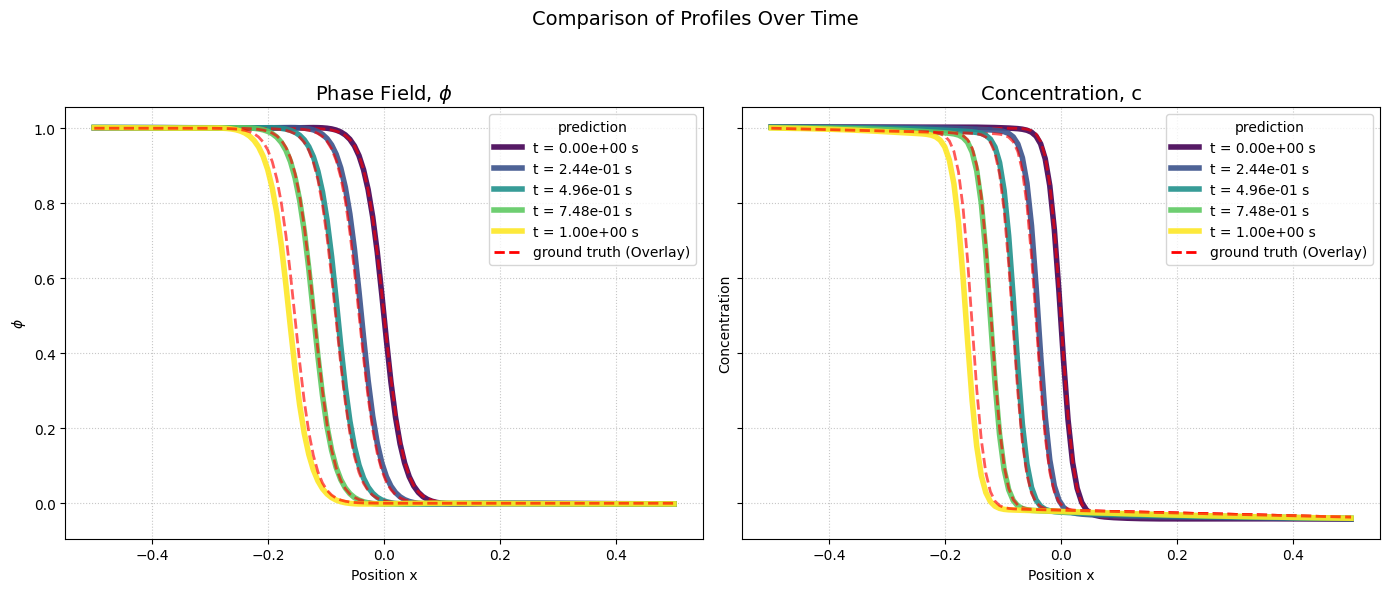

In [18]:
checker.check1(model_prediction, ref_sol, 'prediction', 'ground truth')

--- Starting Comprehensive Solver Verification ---

[1] Verifying Phase Field solution 'φ'...
   - Max absolute difference |Δφ|: 1.42e-01
   - Location: time_index=127, space_index=43
   - FAILURE: Solutions exceed tolerance.
   - Generating 1D diagnostic plot at t = 1.00e+00 s...


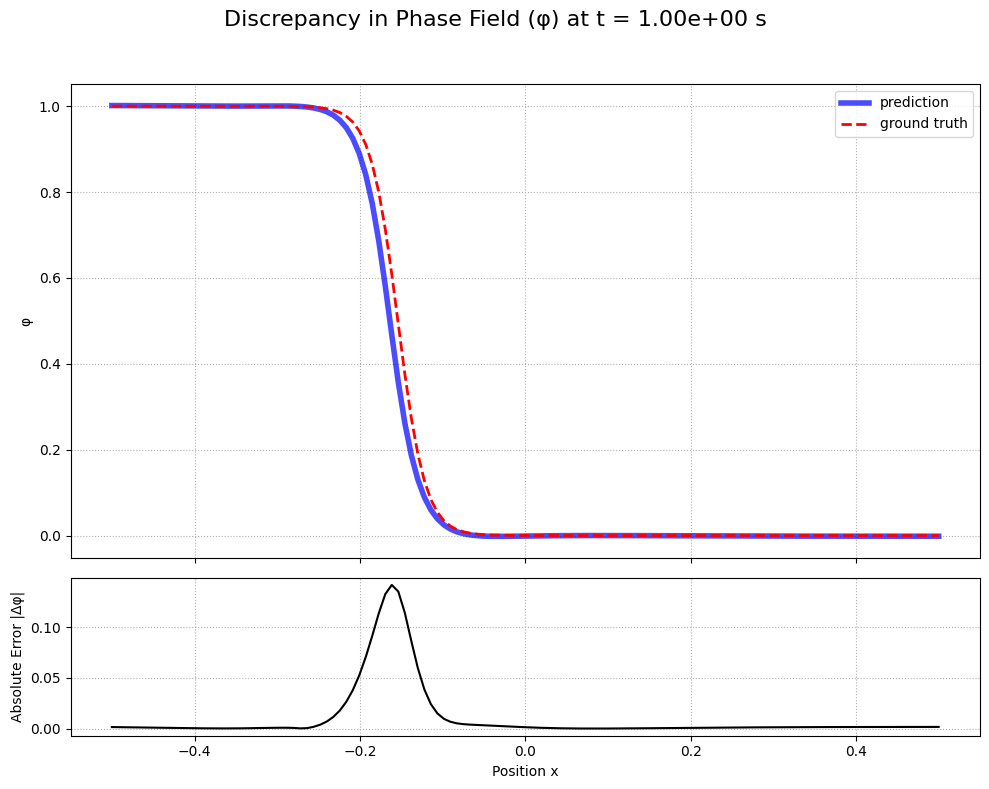


[2] Verifying Concentration solution 'c'...
   - Max absolute difference |Δc|: 2.15e-01
   - Location: time_index=127, space_index=43
   - FAILURE: Solutions exceed tolerance.
   - Generating 1D diagnostic plot at t = 1.00e+00 s...


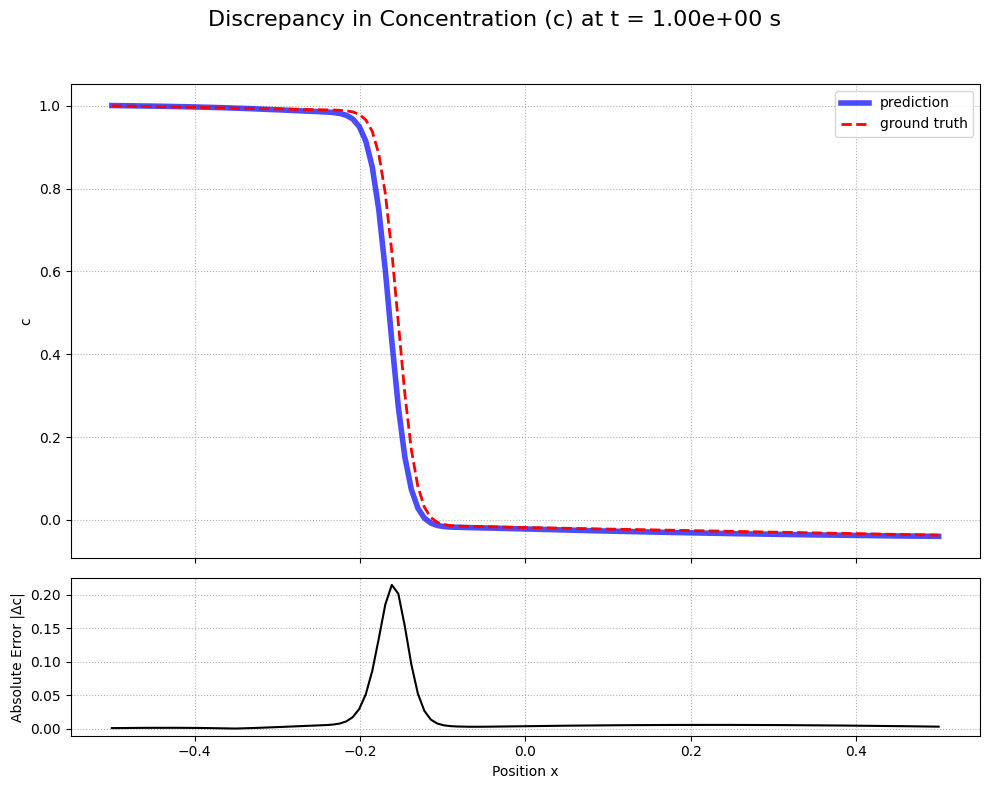


[3] Generating 2D absolute error heatmaps...


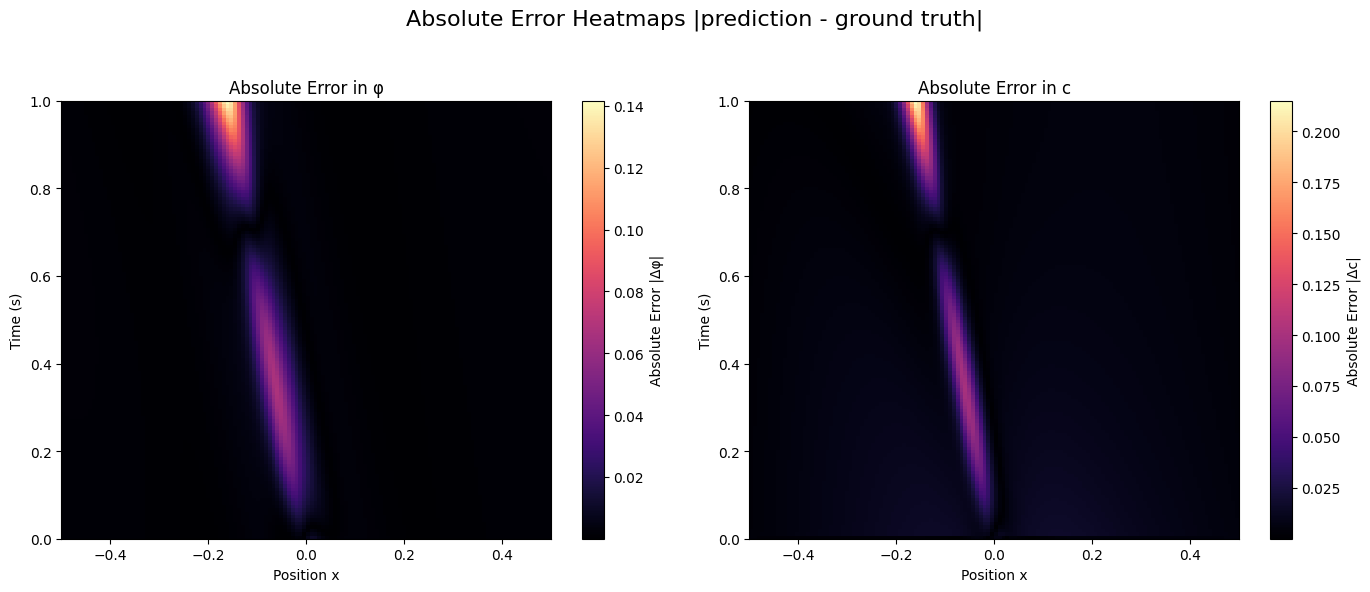


--- Verification Complete ---
❌ Final Result: Some checks failed. See diagnostic plots.

[Summary] Maximum absolute errors:
   - |Δφ|_max = 1.42e-01
   - |Δc|_max = 2.15e-01


In [19]:
checker.check2(model_prediction, ref_sol, 'prediction', 'ground truth')